<a href="https://colab.research.google.com/github/RajBharti25/ILD/blob/master/UNET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [8]:
import numpy as np

import matplotlib.pyplot as plt

import time


# Imports from torch for neural networks
import torch
import torchvision
from torch.autograd import Variable
from torch.utils.data import TensorDataset,DataLoader
from torchvision import models, transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim



In [18]:
!pip install pydicom
import pydicom

     |████████████████████████████████| 35.5MB 76kB/s 


In [ ]:
TrainImages=torch.load('/content/gdrive/My Drive/Colab Notebook/ILD/TrainImages.pt')
TrainLabels=torch.load('/content/gdrive/My Drive/Colab Notebook/ILD/TrainLabels.pt')
TestImages=torch.load('/content/gdrive/My Drive/Colab Notebook/ILD/TestImages.pt')
TestLabels=torch.load('/content/gdrive/My Drive/Colab Notebook/ILD/TestLabels.pt')
#Printing out the data size for verification
print(TrainImages.size())
print(TrainLabels.size())
print(TestImages.size())
print(TestLabels.size())

torch.Size([1398, 1, 512, 512])
torch.Size([1398, 512, 512])
torch.Size([9, 1, 512, 512])
torch.Size([9, 512, 512])


In [9]:

class UNet(nn.Module):
    def contracting_block(self, in_channels, out_channels, kernel_size=3):
        block = torch.nn.Sequential(
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=in_channels, out_channels=out_channels),
                    torch.nn.ReLU(),
                    torch.nn.BatchNorm2d(out_channels),
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=out_channels, out_channels=out_channels),
                    torch.nn.ReLU(),
                    torch.nn.BatchNorm2d(out_channels),
                )
        return block
    
    def expansive_block(self, in_channels, mid_channel, out_channels, kernel_size=3):
            block = torch.nn.Sequential(
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=in_channels, out_channels=mid_channel),
                    torch.nn.ReLU(),
                    torch.nn.BatchNorm2d(mid_channel),
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=mid_channel, out_channels=mid_channel),
                    torch.nn.ReLU(),
                    torch.nn.BatchNorm2d(mid_channel),
                    torch.nn.ConvTranspose2d(in_channels=mid_channel, out_channels=out_channels, kernel_size=3, stride=2, padding=1, output_padding=1)
                    )
            return  block
    
    def final_block(self, in_channels, mid_channel, out_channels, kernel_size=3):
            block = torch.nn.Sequential(
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=in_channels, out_channels=mid_channel),
                    torch.nn.ReLU(),
                    torch.nn.BatchNorm2d(mid_channel),
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=mid_channel, out_channels=mid_channel),
                    torch.nn.ReLU(),
                    torch.nn.BatchNorm2d(mid_channel),
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=mid_channel, out_channels=out_channels, padding=1),
                    torch.nn.ReLU(),
                    torch.nn.BatchNorm2d(out_channels),
                    )
            return  block
    
    def __init__(self, in_channel, out_channel):
        super(UNet, self).__init__()
        #Encode
        self.conv_encode1 = self.contracting_block(in_channels=in_channel, out_channels=64)
        self.conv_maxpool1 = torch.nn.MaxPool2d(kernel_size=2)
        self.conv_encode2 = self.contracting_block(64, 128)
        self.conv_maxpool2 = torch.nn.MaxPool2d(kernel_size=2)
        self.conv_encode3 = self.contracting_block(128, 256)
        self.conv_maxpool3 = torch.nn.MaxPool2d(kernel_size=2)
        # Bottleneck
        self.bottleneck = torch.nn.Sequential(
                            torch.nn.Conv2d(kernel_size=3, in_channels=256, out_channels=512),
                            torch.nn.ReLU(),
                            torch.nn.BatchNorm2d(512),
                            torch.nn.Conv2d(kernel_size=3, in_channels=512, out_channels=512),
                            torch.nn.ReLU(),
                            torch.nn.BatchNorm2d(512),
                            torch.nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, stride=2, padding=1, output_padding=1)
                            )
        # Decode
        self.conv_decode3 = self.expansive_block(512, 256, 128)
        self.conv_decode2 = self.expansive_block(256, 128, 64)
        self.final_layer = self.final_block(128, 64, out_channel)
        
    def crop_and_concat(self, upsampled, bypass, crop=False):
        if crop:
            c = (bypass.size()[2] - upsampled.size()[2]) // 2
            bypass = F.pad(bypass, (-c, -c, -c, -c))
        return torch.cat((upsampled, bypass), 1)
    
    def forward(self, x):
        # Encode
        encode_block1 = self.conv_encode1(x)
        encode_pool1 = self.conv_maxpool1(encode_block1)
        encode_block2 = self.conv_encode2(encode_pool1)
        encode_pool2 = self.conv_maxpool2(encode_block2)
        encode_block3 = self.conv_encode3(encode_pool2)
        encode_pool3 = self.conv_maxpool3(encode_block3)
        # Bottleneck
        bottleneck1 = self.bottleneck(encode_pool3)
        # Decode
        decode_block3 = self.crop_and_concat(bottleneck1, encode_block3, crop=True)
        cat_layer2 = self.conv_decode3(decode_block3)
        decode_block2 = self.crop_and_concat(cat_layer2, encode_block2, crop=True)
        cat_layer1 = self.conv_decode2(decode_block2)
        decode_block1 = self.crop_and_concat(cat_layer1, encode_block1, crop=True)
        final_layer = self.final_layer(decode_block1)
        return  final_layer

In [10]:
# Check availability of GPU
use_gpu = torch.cuda.is_available()
if use_gpu:
    print('GPU is available!')

GPU is available!


In [11]:
net = UNet(in_channel=1,out_channel=4)
if use_gpu:
    net = net.cuda()

In [ ]:
# net.load('/content/gdrive/My Drive/Colab Notebook/ILD/UNET.pt')

In [ ]:
# Creating pytorch dataset
trainDataset = TensorDataset(TrainImages, TrainLabels)
testDataset = TensorDataset(TestImages, TestLabels)
# Creating dataloader
BatchSize = 2
trainLoader = DataLoader(trainDataset, batch_size=BatchSize, shuffle=True)
testLoader = DataLoader(testDataset, batch_size=BatchSize, shuffle=False)

In [13]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr = 0.01, momentum=0.99)

In [ ]:
iterations = 1
trainLoss = []
testLoss = []
start = time.time()

for epoch in range(iterations):
    epochStart = time.time()
    runningLoss = 0
    net.train(True) # For training
    
    for data in trainLoader:
        inputs,labels = data
        # inputs=F.interpolate(inputs, (572,572))
        p2d = (30, 30, 30, 30) # pad last dim by (30, 30) and 2nd to last by (30, 30)
        inputs = F.pad(inputs, p2d, "constant", 0)
        labels=labels[:,:484,:484]
        # Wrap them in Variable
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), \
                Variable(labels.long().cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels.long())
        # Feed-forward input data through the network
        outputs = net(inputs)
        # Compute loss/error
        loss = criterion(outputs, labels.long())
        # loss = criterion(F.softmax(outputs, dim=1), labels)    
        # Initialize gradients to zero
        optimizer.zero_grad()                  
        # Backpropagate loss and compute gradients
        loss.backward()
        # Update the network parameters
        optimizer.step()
        # Accumulate loss per batch
        runningLoss += loss.data.item()
        # print(runningLoss, loss.data.item())
    avgTrainLoss = runningLoss/500.0    
    trainLoss.append(avgTrainLoss)
    plt.plot(range(epoch+1),trainLoss,'r--',label='train')        
    # plt.plot(range(epoch+1),testLoss,'g--',label='test')        
    if epoch==0:
        plt.legend(loc='upper left')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')   
      
    
    epochEnd = time.time()-epochStart
    print('At Iteration: {:.0f} /{:.0f}  ;  Training Loss: {:.6f}; Time consumed: {:.0f}m {:.0f}s '\
          .format(epoch + 1,iterations,avgTrainLoss,epochEnd//60,epochEnd%60))
    # print('At Iteration: {:.0f} /{:.0f}  ;  Testing Loss: {:.6f} ; Time consumed: {:.0f}m {:.0f}s '\
    #       .format(epoch + 1,iterations,avgTestLoss,epochEnd//60,epochEnd%60))
end = time.time()-start
print('Training completed in {:.0f}m {:.0f}s'.format(end//60,end%60))

In [14]:
PATH='/content/gdrive/My Drive/Colab Notebook/ILD/UNET.pt'
# torch.save(model.state_dict(), PATH)

In [ ]:
model=UNet(in_channel=1,out_channel=4)
model=model.cuda()
model.load_state_dict(torch.load(PATH))
model.eval()

In [ ]:
randIdx = 30
testImg = TrainImages[randIdx]
p2d = (30, 30, 30, 30) # pad last dim by (30, 30) and 2nd to last by (30, 30)
testImg=F.pad(testImg, p2d, "constant", 0)
testLab = TrainLabels[randIdx].numpy()

# Feed-forward
segImg = net(Variable(testImg).unsqueeze(0).cuda())
# Applying softmax to get class probabilities
segImg_np = F.softmax(segImg).data.cpu().squeeze(0).numpy()

# Displaying segmented output and ground truth
plt.subplot(231)
plt.imshow(segImg_np[0,:,:],cmap='gray')
plt.title('Channel 1')
plt.subplot(232)
plt.imshow(segImg_np[1,:,:],cmap='gray')
plt.title('Channel 2')
plt.subplot(233)
plt.imshow(segImg_np[2,:,:],cmap='gray')
plt.title('Channel 3')
plt.subplot(234)
plt.imshow(segImg_np[3,:,:],cmap='gray')
plt.title('Channel 4')
plt.subplot(235)
plt.imshow(testImg.reshape(512,512),cmap='gray')
plt.title('Original')

In [ ]:
inputs=F.interpolate(inputs, (572,572))
print(inputs.shape)
labels=labels[:,:484,:484]
labels.shape

torch.Size([2, 1, 572, 572])


torch.Size([2, 484, 484])

In [ ]:
p2d = (30, 30, 30, 30) # pad last dim by (30, 30) and 2nd to last by (30, 30)
out = F.pad(t4d, p2d, "constant", 0)

In [ ]:
a=TrainImages[11,:,:,:].unsqueeze(0)
a=F.interpolate(a, size=(572,572))
print(a.shape)
b=TrainLabels[11,:484,:484].unsqueeze(0)
print(b.shape)

In [ ]:
output=unet(a)

In [ ]:
output.shape

torch.Size([1, 4, 484, 484])

(4, 484, 484)
892075


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  after removing the cwd from sys.path.


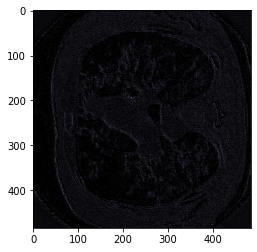

In [ ]:
a1=output.data.cpu().squeeze(0).numpy()
print(a1.shape)
plt.imshow(a1[3,:,:],cmap='bone')
print(len(np.unique(F.softmax(output.data))))

In [ ]:
plt.imshow(a1[3,0,:,:],cmap='bone')

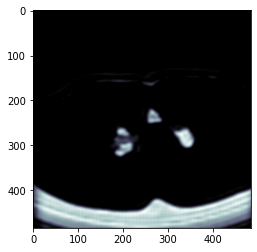

In [50]:
a=pydicom.read_file('/content/NI6C38~1.IMA').pixel_array
a=a/np.amax(a)
a=torch.from_numpy(a).unsqueeze(0).unsqueeze(0)
p2d=(30,30,30,30)
a=F.pad(a,p2d,"constant", 0)
a=a.type(torch.FloatTensor)
a.shape
out=model(a.cuda()).squeeze(0)
plt.imshow(out[3].data.cpu().numpy(),cmap='bone')

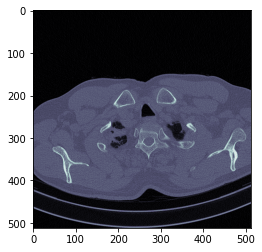

In [51]:
plt.imshow(pydicom.read_file('/content/NI6C38~1.IMA').pixel_array, cmap='bone')

In [ ]:
unet = Unet(in_channel=1,out_channel=4)
#out_channel represents number of segments desired
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(unet.parameters(), lr = 0.01, momentum=0.99)
optimizer.zero_grad()       
outputs = unet(inputs)
# permute such that number of desired segments would be on 4th dimension
outputs = outputs.permute(0, 2, 3, 1)
m = outputs.shape[0]
# Resizing the outputs and label to caculate pixel wise softmax loss
outputs = outputs.resize(m*width_out*height_out, 2)
labels = labels.resize(m*width_out*height_out)
loss = criterion(outputs, labels)
loss.backward()
optimizer.step()